## 1. Standard Import

In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional  as F

## 2. Get the Data

In [4]:
mnist=pd.read_csv("Mnist_combined.csv",index_col=0)

In [5]:
mnist.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
mnist.shape

(70000, 785)

## 3. Convert the Data into Tensor Dataset

In [7]:
mnist = mnist.sample(20000)

In [8]:
mnist.shape

(20000, 785)

In [9]:
X = mnist.drop(labels = "label" ,axis = 1)

# In this , we actually don't need labels
Y = mnist["label"]

In [10]:
Y.head()

22436    0
55785    0
56901    2
16572    4
3920     7
Name: label, dtype: int64

In [11]:
data_np = X.to_numpy()
labels_np = Y.to_numpy()

In [12]:
data_np[0].shape

(784,)

In [13]:
labels_np.shape

(20000,)

In [14]:
labels_np

array([0, 0, 2, ..., 0, 1, 1], dtype=int64)

In [15]:
#labels_np=labels_np[:,None]

In [16]:
# Normalize the data(predictors) to a range of [0 1]
dataNorm = data_np / np.max(data_np)

In [17]:
dataNorm

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Converting Numpy array to Pytorch Array

In [18]:
# convert to a pytorch tensor
data = torch.tensor(dataNorm).float()

# Note: "long" format for CCE : Multiclass classification
labels = torch.tensor(labels_np).long() 

In [19]:
labels

tensor([0, 0, 2,  ..., 0, 1, 1])

## 4. Create and validate the model

In [20]:
# create a class for the model
def createTheMNIST_AE_Net(n_enc, n_bottle, LR):

    class MNIST_AE_Net(nn.Module):
        
        def __init__(self, n_enc, n_bottle):
            super().__init__()

            ### Input layer
            self.input = nn.Linear(784,n_enc)

            ### Encode Layer
            self.enc = nn.Linear(n_enc,n_bottle)
            
            ### Latent layer
            self.lat = nn.Linear(n_bottle,n_enc)
            
            ### decoder layer
            self.dec = nn.Linear(n_enc,784)
            

        # forward pass
        def forward(self,x):
            
            # Input  Layer
            x = F.relu( self.input(x) ) 
            # Encode layer
            x = F.relu( self.enc(x) )
            # latent Layer
            x = F.relu(self.lat(x))
            
            # since, Predictors have range between 0 and 1
            # Therefore, using sigmoid as an activation function
            y = torch.sigmoid(self.dec(x))
            
            return y
        

    # create the model instance
    ANN_AE_model = MNIST_AE_Net(n_enc, n_bottle)

    # loss function : Negative Log-Likelihood Loss function
    lossfunc = nn.MSELoss()

    # optimizer
    optimizer = torch.optim.Adam(ANN_AE_model.parameters(),lr=LR)

    return ANN_AE_model, lossfunc, optimizer

## 5. Model Training

In [21]:
def function2trainTheModel(Model, lossfunc, optimizer, predictors, epochs):

    # initialize losses
    losses = torch.zeros(epochs)

    # loop over epochs
    for epochi in range(epochs):

        # select a random set of images
        randomidx = np.random.choice(predictors.shape[0],size=32)
        X = predictors[randomidx,:]

        # forward pass and loss
        yHat = Model(X)
        loss = lossfunc(yHat,X)

        # backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # losses in this epoch
        losses[epochi] = loss.item()
        # end epochs
        
    #print(losses) 
    #print(torch.mean(losses))
    #print(np.round(torch.mean(losses),3))
    Final_loss = torch.mean(losses[-3:])
    
    # function output
    return Final_loss, Model

## 6. Experiment

In [22]:
# Note! this cell takes ~25 minutes with initial N settings

# specific the number of units
N_encdec_units = np.linspace(10,500,8).astype(int)
N_bottle_units = np.linspace(5,100,6).astype(int)


# initialize results matrix
exp_results = np.zeros((len(N_encdec_units),len(N_bottle_units)))

In [23]:
import sys

In [24]:
# start the experiment!
# Time taken : 8mins
for ei,nenc in enumerate(N_encdec_units):
    
    for bi,nbot in enumerate(N_bottle_units):

        # build/train a model        
        # Create the network createTheMNIST_AE_Net(n_enc, n_bottle, LR)
        ANN_AEmodel, Lossfunc, Optimizer = createTheMNIST_AE_Net(n_enc=nenc,
                                                                 n_bottle=nbot,
                                                                 LR=0.001)

        # Model Training :taking only losses as an output
        Losses =  function2trainTheModel(Model=ANN_AEmodel, 
                                         lossfunc=Lossfunc, 
                                         optimizer=Optimizer, 
                                         predictors=data,
                                         epochs=200)[0]

        
        #exp_results[ei,bi] = np.mean(losses[-1])
        exp_results[ei,bi] = Losses
        
        # send update message
        currentIter = ei*len(N_bottle_units) + bi + 1
        totalIters  = len(N_bottle_units)*len(N_encdec_units)
        
        msg = 'Finished experiment : {}/{}'.format(currentIter,totalIters)
        sys.stdout.write('\r' + msg)

Finished experiment 48/48

In [25]:
exp_results

array([[0.07498825, 0.06534345, 0.06258521, 0.06705509, 0.06859145,
        0.06731512],
       [0.06459539, 0.05764743, 0.05824359, 0.05760999, 0.05247259,
        0.05561414],
       [0.06260333, 0.05057538, 0.05113214, 0.04651992, 0.04683212,
        0.04497629],
       [0.05521895, 0.04333046, 0.04273157, 0.04353027, 0.04101378,
        0.04027442],
       [0.06096963, 0.04085911, 0.03618659, 0.03911996, 0.03776079,
        0.04221699],
       [0.04618346, 0.04026394, 0.0410268 , 0.0364428 , 0.03390481,
        0.03748642],
       [0.06591707, 0.03772121, 0.03633726, 0.0344619 , 0.03756287,
        0.03648501],
       [0.05557218, 0.03679908, 0.03395737, 0.03238731, 0.03048103,
        0.03460583]])

## 7. Results Visualization

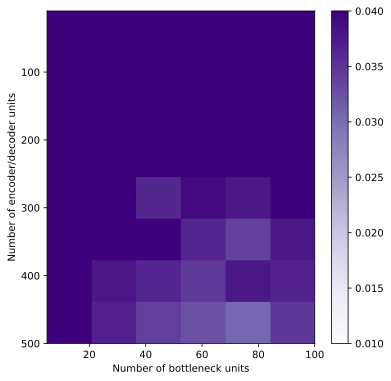

In [26]:
# show the results matrix
fig = plt.figure(figsize=(6,6), dpi=135)

x_min = N_bottle_units[0]
x_max = N_bottle_units[-1]
y_min = N_encdec_units[-1]
y_max = N_encdec_units[0]

plt.imshow(exp_results, aspect='auto',         # data and aspect ratio
           vmin=.01,vmax=.04, cmap='Purples',  # color range and palette
           extent=[ x_min,x_max,y_min,y_max, ]) # xy axis ticks
           

plt.xlabel('Number of bottleneck units')
plt.ylabel('Number of encoder/decoder units')
plt.colorbar()

plt.show()

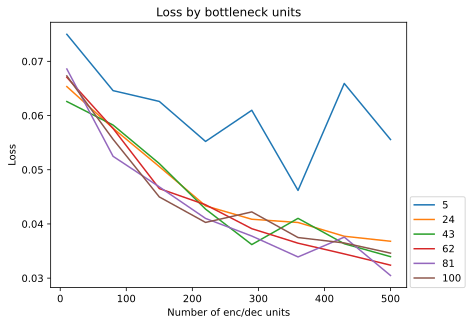

In [27]:
# perhaps a line plot will better reveal the sudden transition

# column-wise plotting
plt.plot(N_encdec_units,exp_results)

plt.legend(N_bottle_units,loc=(1.01,0))

plt.xlabel('Number of enc/dec units')
plt.title('Loss by bottleneck units')
plt.ylabel('Loss')

plt.show()